In [ ]:
!pip install evaluate
!pip install datasets
!pip install fsspec==2023.9.2


In [ ]:
#from google.colab import drive
from datasets import DatasetDict, ClassLabel, Dataset, load_dataset
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import (
  AutoConfig,
  AutoTokenizer,
  AutoModelForSequenceClassification ## capa de clasificación
)
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
from datasets import DatasetDict, ClassLabel
import pandas as pd
import evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report
import numpy as np

In [ ]:
#drive.mount('/content/drive')

In [ ]:
ruta = 'data_for_trainning_encoder.parquet'
#ruta = '/content/drive/My Drive/TFM/data_for_trainning_encoder.parquet'

df = pd.read_parquet(ruta)
df


###subset aleatorio pero manteniendo proporcion de busqueda mercadona-hacendado
n = 4308
df['sentimiento_producto'] =df['sentimiento_producto'].astype(str).str.strip()
df_balanceado = (df.groupby('sentimiento_producto', group_keys=False).apply(lambda x: x.sample(n=n//2, random_state=69)))

df = df_balanceado


/tmp/ipython-input-882625085.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanceado = (df.groupby('sentimiento_producto', group_keys=False).apply(lambda x: x.sample(n=n//2, random_state=69)))


In [ ]:
df.columns

Index(['index', 'User', 'tweets', 'search', 'fecha_captura',
       'explica_sentimiento', 'explica_sentimiento_2', 'sentimiento_final',
       'proteccion_datos', 'deteccion_producto', 'producto',
       'sentimiento_producto', 'categoria', 'comparativa_producto',
       'comparativa_sentimiento', 'imagen_marca'],
      dtype='object')

In [ ]:
#df['sentimiento_producto'] =df['sentimiento_producto'].astype(str).str.strip()
df['sentimiento_producto'].value_counts()

,count
sentimiento_producto,
NO,2154
SI,2154


In [ ]:
#df['sentimiento_producto'].astype(str).str.strip().value_counts()

In [ ]:
#nombre_modelo_nuevo= 'Spanish_twitter_sentiment_analysis_mini'


nombre_modelo_nuevo= 'mercadona_sentiment_product_detection'



In [ ]:
df_for_training = df[['tweets', 'sentimiento_producto']].copy()

df_for_training = df_for_training.rename(columns={'tweets': 'text', 'sentimiento_producto':'labels' })
df_for_training['labels'] = (df_for_training['labels']
                              .astype(str)
                              .str.strip()
                              .str.upper()
                              .map({'SI': 1, 'NO': 0}))
df_for_training

,text,labels
887,Llevo una tortilla de patata hacendado a Londr...,0
8918,un supermercado como mercadona que ha ganado u...,0
6363,Lo de vaciar supermercados en zonas no afectad...,0
5229,Estoy un poco triste?? Pos al mercadona a por ...,0
6887,El ayuntamiento de Málaga haciendo lo que mejo...,0
...,...,...
6086,"Hola, @Mercadona las pajitas de cartón en los ...",1
5332,El mejor jabón de manos es el de Mercadona que...,1
1387,Súbanse al carro del Negredo de hacendado !!!,1
2309,"500 ml de helado sabor a ""plátano choco nuez"" ...",1


In [ ]:
dataset = Dataset.from_pandas(df_for_training)
dataset

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 4308
})

In [ ]:
model_name = 'microsoft/mdeberta-v3-base' #"EuroBERT/EuroBERT-210m" #"BSC-LT/roberta-large-bne"   #base

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False ) #use_fast=False en modelos Plant-TL



def preprocess_function(examples):
    # Tokenizar el texto

    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256) ##maxlen recomendado en deberta. No poner en resto si no da avisos

    #return tokenizer(examples['text'], padding="max_length", truncation=True)



dataset = dataset.map(preprocess_function, batched=True) # preprocess_function


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/4308 [00:00<?, ? examples/s]

In [ ]:
# 1. División inicial: 90% train+dev, 10% test
split_1 = dataset.train_test_split(test_size=0.1, shuffle=True, seed=42)

# 2. División secundaria: de ese 90%, separamos 11.11% para validación → (10% del total original)
split_2 = split_1['train'].train_test_split(test_size=0.1111, shuffle=True, seed=69)

# 3. Armamos todo en un DatasetDict
final_splits = DatasetDict({
    'train': split_2['train'],
    'validation': split_2['test'],
    'test': split_1['test']
})

# 4. Verificación de tamaños
print(f"Train: {len(final_splits['train'])}")
print(f"Validation: {len(final_splits['validation'])}")
print(f"Test: {len(final_splits['test'])}")

Train: 3446
Validation: 431
Test: 431


In [ ]:
from collections import Counter

def print_label_distribution(split_name, dataset):
    labels = dataset['labels']
    total = len(labels)
    counter = Counter(labels)
    print(f"Distribución en {split_name} (total {total}):")
    for label, count in counter.items():
        print(f"  Clase {label}: {count} ({count/total:.2%})")
    print()

# Asumiendo que tienes final_splits como DatasetDict
print_label_distribution('Train', final_splits['train'])
print_label_distribution('Validation', final_splits['validation'])
print_label_distribution('Test', final_splits['test'])

Distribución en Train (total 3446):
  Clase 1: 1726 (50.09%)
  Clase 0: 1720 (49.91%)

Distribución en Validation (total 431):
  Clase 1: 209 (48.49%)
  Clase 0: 222 (51.51%)

Distribución en Test (total 431):
  Clase 1: 219 (50.81%)
  Clase 0: 212 (49.19%)



In [ ]:
dataset = final_splits

In [ ]:
### modelo.

In [ ]:
SEED = 69

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)



id2label = {0: "NO", 1: "SI"}
label2id = {"NO": 0, "SI": 1}



def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
    device_map="auto",


    trust_remote_code=True,
    #hiden modelo eurobert
    # hidden_dropout=0.1,
    # attention_dropout=0.1,

    #hiden modelo roberta
    # para hacer dropout al modelo.

    #hidden_dropout_prob=0.1,  # dropout en capas ocultas cuando se activa afecta a la cabeza de clasificacion
    #attention_probs_dropout_prob=0.1,  # dropout en atención

    #classifier_dropout=0.3,     # dropout en clasificación para ajustar solamente la cabeza.

    )

model = model_init()
print(model.config)


# # imprimir layers entrenables
for name, param in model.named_parameters():
  print(name, param.requires_grad)

print(100*("="))
print('dropout')
# Verificar  dropout
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Dropout):
        print(f"{name}: {module}")

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2Config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NO",
    "1": "SI"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NO": 0,
    "SI": 1
  },
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "torch_dtype": "float32",
  "transformers_version": "4.55.1",
  "type_vocab_size": 0,
  "vocab_size": 251000
}

deberta.embeddings.word_embeddings.weight True
deberta.embeddings.LayerNorm.weight True
deberta.embeddin

In [ ]:
#NO-MODIFY: VARIABLE NAME
training_args =  TrainingArguments(
    output_dir=nombre_modelo_nuevo,
    learning_rate= 5e-05 , ### 2e-5  [1e-5, 1e-6, 1e-5,  2e-5, 3e-5, 1e-4 ] de minimos locales a no converger # 2e-5 estandar
    per_device_train_batch_size=16, #8
    per_device_eval_batch_size=16, #8
    num_train_epochs= 10,
    weight_decay=0.1,
    eval_strategy="steps",
    #save_strategy="steps",
    save_strategy="best",
    save_total_limit=3,
    eval_steps=20, #50,
    logging_strategy="steps",
    logging_steps=20, #50,
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
    seed=SEED,
    metric_for_best_model="f1_score",
    greater_is_better=True,
    #bf16=True, #
    full_determinism=True,
    gradient_accumulation_steps=16 #

)

In [ ]:
accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1_score_value = f1_score.compute(predictions=predictions, references=labels)["f1"]

    return {
        "accuracy": accuracy_value,
        "f1_score": f1_score_value,
    }

/tmp/ipython-input-714299730.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1 Score
20,0.604800,0.469137,0.832947,0.830189
40,0.407000,0.362918,0.851508,0.848341
60,0.300300,0.348248,0.865429,0.866359
80,0.210800,0.563398,0.816705,0.835759
100,0.173500,0.518052,0.844548,0.853392
120,0.119500,0.486643,0.853828,0.858427


{'eval_loss': 0.48664307594299316, 'eval_accuracy': 0.8538283062645011, 'eval_f1_score': 0.8584269662921349, 'eval_runtime': 8.1135, 'eval_samples_per_second': 53.121, 'eval_steps_per_second': 3.328, 'epoch': 8.592592592592592}


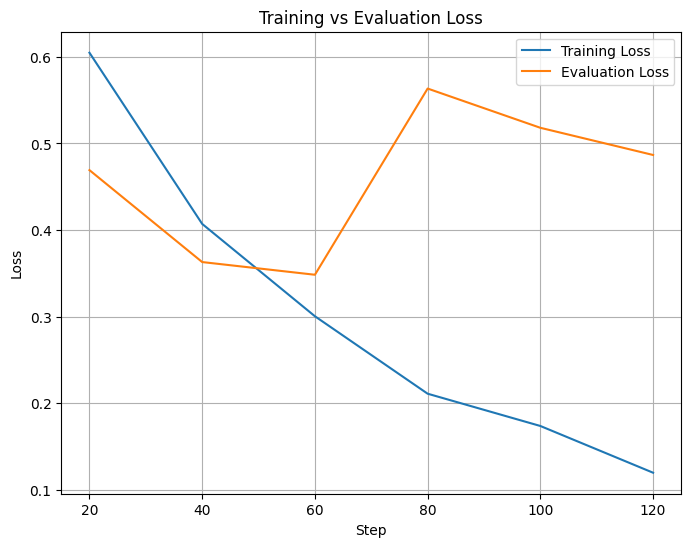

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= dataset['train'],
    eval_dataset= dataset['validation'],
    tokenizer=tokenizer ,
    compute_metrics= compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] #
)



trainer.train()
metrics = trainer.evaluate()
print(metrics)


# Extraemos los logs de entrenamiento
history = pd.DataFrame(trainer.state.log_history)

# A veces los logs pueden tener pasos donde no se evalúa. Filtramos filas con 'loss' y 'eval_loss'
train_loss = history[history['loss'].notna()][['step', 'loss']]
eval_loss = history[history['eval_loss'].notna()][['step', 'eval_loss']]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_loss['step'], train_loss['loss'], label='Training Loss')
plt.plot(eval_loss['step'], eval_loss['eval_loss'], label='Evaluation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.48664307594299316, 'eval_accuracy': 0.8538283062645011, 'eval_f1_score': 0.8584269662921349, 'eval_runtime': 8.1062, 'eval_samples_per_second': 53.169, 'eval_steps_per_second': 3.331, 'epoch': 8.592592592592592}


In [ ]:
### estas son las metricas que estoy cogiendo.
trainer.evaluate(dataset['test'])

{'eval_loss': 0.5101224184036255,
 'eval_accuracy': 0.8468677494199536,
 'eval_f1_score': 0.8526785714285714,
 'eval_runtime': 8.1544,
 'eval_samples_per_second': 52.855,
 'eval_steps_per_second': 3.311,
 'epoch': 8.592592592592592}

metricas
{'test_loss': 0.5101224184036255, 'test_accuracy': 0.8468677494199536, 'test_f1_score': 0.8526785714285714, 'test_runtime': 8.174, 'test_samples_per_second': 52.728, 'test_steps_per_second': 3.303}
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       212
           1       0.83      0.87      0.85       219

    accuracy                           0.85       431
   macro avg       0.85      0.85      0.85       431
weighted avg       0.85      0.85      0.85       431



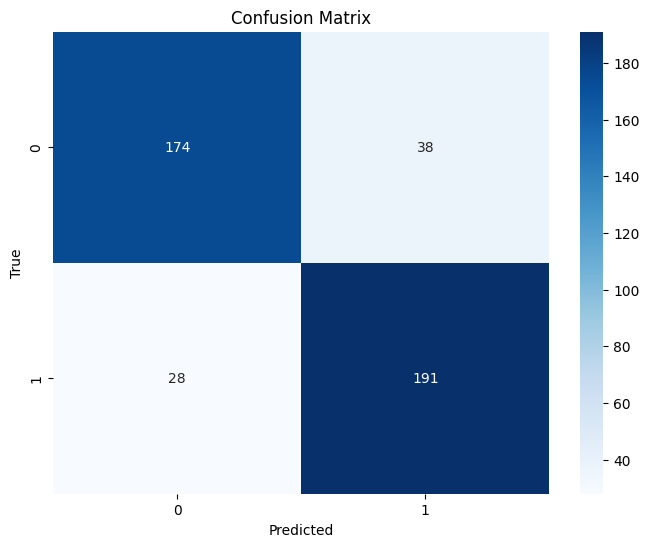

In [ ]:
### Crear una matriz de confusión
# Obtener predicciones
predicciones_trainer = trainer.predict(dataset['test'])

print("metricas")
print(predicciones_trainer.metrics)

# Las predicciones pueden venir como logits, necesitamos el argmax
y_pred = np.argmax(predicciones_trainer.predictions, axis=1)
# Etiquetas verdaderas
y_true = predicciones_trainer.label_ids
cm = confusion_matrix(y_true, y_pred)

# print("Confusion Matrix:")
# print(cm)

print("Classification Report:")
print(classification_report(y_true, y_pred))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Predicción final (clase con mayor probabilidad)
y_pred = np.argmax(predicciones_trainer.predictions, axis=1)
y_true = predicciones_trainer.label_ids

# Obtener los textos originales
textos = dataset['test']['text']

# Crear un DataFrame para inspeccionar
df_resultados = pd.DataFrame({
    'texto': textos,
    'etiqueta_verdadera': y_true,
    'etiqueta_predicha': y_pred
})

falsos_positivos = df_resultados[(df_resultados.etiqueta_verdadera == 0) & (df_resultados.etiqueta_predicha == 1)]
falsos_negativos = df_resultados[(df_resultados.etiqueta_verdadera == 1) & (df_resultados.etiqueta_predicha == 0)]
falsos_negativos

,texto,etiqueta_verdadera,etiqueta_predicha
3,"Si, apoyo al ""G2 de Hacendado"" como dicen los ...",1,0
14,Dominio total es: Hacendado sacó tequeños,1,0
45,Nos han colado al Mbappé de hacendado,1,0
55,Hay gente que está enganchá a los porros o a l...,1,0
80,A veces una chica solo necesita 100 gramos de ...,1,0
85,Al pan pan y a al vaso de leche de hacendado c...,1,0
99,Pero yo tengo un granizado de limón de Hacenda...,1,0
105,Amiwos no compren la imitación de redbull marc...,1,0
109,¿Es necesario este look Juego de tronos meets ...,1,0
129,Apareció el Superman de hacendado,1,0


In [ ]:
falsos_positivos

,texto,etiqueta_verdadera,etiqueta_predicha
7,Se la chupo tan fuerte y sin avisar q le dejo ...,0,1
32,Un día de estos me compro un tinte barato del ...,0,1
33,la gente q no usa el tomate frito d hacendado ...,0,1
44,Flandria Virginia.\nLa marca Hacendado de los ...,0,1
83,Vaya hachas de hacendado #Conquis10ETB,0,1
87,Lmfao el matt ox de hacendado me tiene block xdd,0,1
124,El guacamole del Mercadona. Menudo invento.,0,1
139,Estimados señores de @Mercadona:\nNecesito ver...,0,1
147,será esta mi primera vez durmiendo de seguido ...,0,1
157,"Una vez más, los Morancos siendo ellos César ...",0,1


In [ ]:
df

,index,User,tweets,search,fecha_captura,explica_sentimiento,explica_sentimiento_2,sentimiento_final,proteccion_datos,deteccion_producto,producto,sentimiento_producto,categoria,comparativa_producto,comparativa_sentimiento,imagen_marca
887,323601,I caught myself,Llevo una tortilla de patata hacendado a Londr...,hacendado,2020-01-04,Sentimiento: neutral. Razón: El mensaje es una...,Sentimiento: neutral. Razón: El mensaje es una...,neutral,NO,SI,1: tortilla de patata hacendado,NO,No aplica,No aplica,No aplica,NO
8918,112429,luisa,un supermercado como mercadona que ha ganado u...,mercadona,2025-05-20,Sentimiento: negativo. Razón: El texto expresa...,Sentimiento: negativo. Razón: El mensaje expre...,negativo,NO,NO,No aplica,NO,No aplica,No aplica,No aplica,SI
6363,31398,Karlsen,Lo de vaciar supermercados en zonas no afectad...,mercadona,2024-11-03,Sentimiento: negativo. Razón: El mensaje expre...,Sentimiento: negativo. Razón: El mensaje expre...,negativo,NO,NO,No aplica,NO,No aplica,No aplica,No aplica,SI
5229,84427,PORCAHONTAS,Estoy un poco triste?? Pos al mercadona a por ...,mercadona,2021-09-12,Sentimiento: positivo. Razón: El mensaje expre...,Sentimiento: positivo. Razón: El mensaje expre...,positivo,NO,SI,1: nachos 2: guacamole,NO,No aplica,No aplica,No aplica,NO
6887,30726,Antonio.M,El ayuntamiento de Málaga haciendo lo que mejo...,mercadona,2019-07-11,Sentimiento: negativo. Razón: El texto expresa...,Sentimiento: negativo. Razón: El mensaje expre...,negativo,NO,SI,No aplica,NO,No aplica,No aplica,No aplica,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6086,148050,Edu Lorente-Sorolla,"Hola, @Mercadona las pajitas de cartón en los ...",mercadona,2022-04-26,Sentimiento: negativo. Razón: El usuario expre...,Sentimiento: negativo. Razón: El mensaje expre...,negativo,NO,SI,1: pajitas de cartón 2: batidos 3: pajitas de ...,SI,1: Limpieza y hogar : Menaje y conservación de...,SI,pajas de cartón : negativo,NO
5332,293819,Dani,El mejor jabón de manos es el de Mercadona que...,mercadona,2022-02-02,Sentimiento: positivo. Razón: El mensaje expre...,Sentimiento: positivo. Razón: El mensaje expre...,positivo,NO,SI,1: jabón de manos 2: piruleta,SI,1: Cuidado facial y corporal : Gel y jabón de ...,SI,jabón de manos: positivo,SI
1387,337714,MOISITO,Súbanse al carro del Negredo de hacendado !!!,hacendado,2021-11-29,Sentimiento: positivo. Razón: El mensaje utili...,Sentimiento: positivo. Razón: El mensaje utili...,positivo,NO,SI,1: Negredo de hacendado,SI,1: Charcutería y quesos : Embutido curado \n,NO,No aplica,SI
2309,334172,A,"500 ml de helado sabor a ""plátano choco nuez"" ...",hacendado,2016-07-28,Sentimiento: positivo. Razón: El mensaje expre...,Sentimiento: positivo. Razón: El mensaje expre...,positivo,NO,SI,"1: helado sabor a ""plátano choco nuez""",SI,1: Congelados : Helados \n,NO,No aplica,NO


In [ ]:
# # Ruta al checkpoint que quieres cargar
# best_checkpoint_path = "mercadona_sentiment_product_detection/checkpoint-60" #eurobert 140

# # Cargar el modelo desde el checkpoint
# model = AutoModelForSequenceClassification.from_pretrained(best_checkpoint_path)

# # Volver a crear el Trainer con el modelo cargado
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset= dataset['train'],
#     eval_dataset= dataset['validation'],
#     compute_metrics=compute_metrics
# )

# # Evaluar
# metrics = trainer.evaluate()
# print(metrics)

In [ ]:
### estas son las metricas que estoy cogiendo.
trainer.evaluate(dataset['test'])


{'eval_loss': 0.5101224184036255,
 'eval_accuracy': 0.8468677494199536,
 'eval_f1_score': 0.8526785714285714,
 'eval_runtime': 8.1458,
 'eval_samples_per_second': 52.911,
 'eval_steps_per_second': 3.315,
 'epoch': 8.592592592592592}

metricas
{'test_loss': 0.5101224184036255, 'test_accuracy': 0.8468677494199536, 'test_f1_score': 0.8526785714285714, 'test_runtime': 8.1683, 'test_samples_per_second': 52.765, 'test_steps_per_second': 3.305}
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       212
           1       0.83      0.87      0.85       219

    accuracy                           0.85       431
   macro avg       0.85      0.85      0.85       431
weighted avg       0.85      0.85      0.85       431



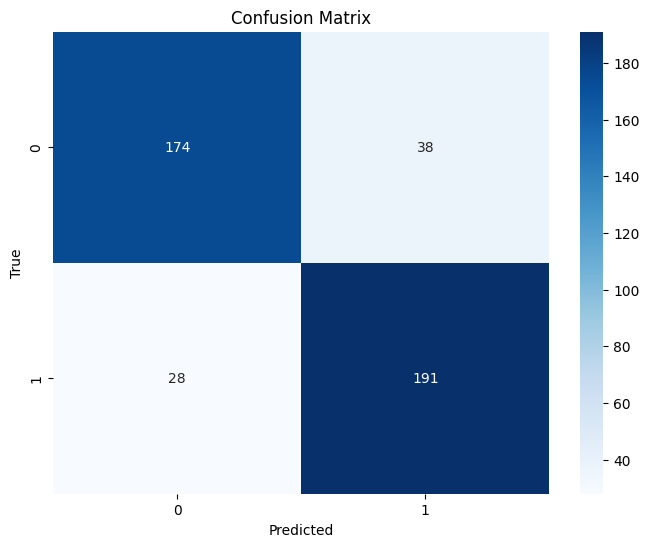

In [ ]:
### Crear una matriz de confusión
# Obtener predicciones
predicciones_trainer = trainer.predict(dataset['test'])

print("metricas")
print(predicciones_trainer.metrics)

# Las predicciones pueden venir como logits, necesitamos el argmax
y_pred = np.argmax(predicciones_trainer.predictions, axis=1)
# Etiquetas verdaderas
y_true = predicciones_trainer.label_ids
cm = confusion_matrix(y_true, y_pred)

# print("Confusion Matrix:")
# print(cm)

print("Classification Report:")
print(classification_report(y_true, y_pred))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
from huggingface_hub import login
login(token="")
#trainer.push_to_hub("mercadona_sentiment_product_detection_mini")